## Generate Training/Testing Data

This notebook will parse through the preprocessed data from preprocess.ipynp and break it into training and testing data sets. The general strategy will be to create windows of length 1 second (125 points), with a sliding length of 10 points.

Import stuff

In [1]:
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import numpy as np
import pywt
import numpy as np

!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

Define some constants

In [2]:
#window size is 1 second (125 points)
WIN_LEN = 125

#amount of points to slide forward for next window
WIN_SLIDE = 10

#at least 75% of the indices within a given window should be within the valid indices
#TODO: is this a good threshold? the lower this number is, it could affect performance quite a bit
MIN_VALID_PERC = 0.9

#define the frequencies for the cwt
wavelet = 'morl'
scales = np.arange(2,64)  #this corresponds to ~1.5Hz - 50Hz
wavelet_freqs = pywt.scale2frequency(wavelet, scales)*125

Download the preprocessed data (as generated from preprocess.ipynp). Note that this is ~500MB so it will take some time.

In [3]:
#the link to download data_labels_preprocessed.pkl
file_id = '1vcBM0UOxoUhUUHTKzNDpRFVq9pn5eA0g'

#load in the data and labels
gdd.download_file_from_google_drive(file_id=file_id, dest_path='./data_labels_preprocessed.pkl')
df = pd.read_pickle('data_labels_preprocessed.pkl')

Define a function to window the data

In [4]:
def get_windows(row, channel):
    record_name = row['record_name']
    print(record_name)

    #check if there is no data here
    if row[channel] is None: return []

    #set up the data and labels
    coefficients = row['cwt_'+channel]
    data = row[channel]
    N = np.shape(coefficients)[1]
    QRS_labels = np.zeros(N).astype(int)
    QRS_labels[row['qrs_'+channel]] = 1
    valid_inds = row['inds_to_keep_'+channel]

    windows = []
    #now loop through windows of length WIN_LEN and generate windows with labels

    for i in range(0, N-WIN_LEN, WIN_SLIDE):
        #get the current window indices
        tmp_inds = range(i,i+WIN_LEN)

        #confirm that at least 90% of the points are within the valid indices
        if sum(np.isin(tmp_inds, valid_inds))/WIN_LEN < MIN_VALID_PERC: continue

        #grab the data for this window
        tmp_win = coefficients[:,tmp_inds]
        tmp_labels = QRS_labels[tmp_inds]
        tmp_data = data[tmp_inds]

        #plot
        power = (abs(tmp_win))**2
        levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
        contourlevels = np.log2(levels)
        
        if i == 5000:
            plt.figure(figsize=(10,6))
            ax1 = plt.subplot(211)
            plt.plot(tmp_labels, 'b', label='Label')
            plt.plot(tmp_data, label='ECG')
            plt.legend(loc=1)
            ax2 = plt.subplot(212, sharex=ax1)
            plt.contourf(range(len(tmp_data)), wavelet_freqs, np.log2(power), contourlevels, extend='both', cmap='jet')
            plt.ylabel('Hz')
            plt.xlabel('Time (seconds)')
            plt.tight_layout()
            plt.savefig('cwt/%s_%s.png' % (record_name, channel), dpi=125)
            plt.show()
            plt.close()
        

        #add to list
        tmp_dict = {'window': tmp_win, 'label': tmp_labels, 'data': tmp_data}
        windows.append(tmp_dict)

    return windows




Do the actual data windowing on each channel separately. Then combine both channels and keep 90% for training, 10% for testing

sel100
sel102
sel103
sel104
sel114
sel116


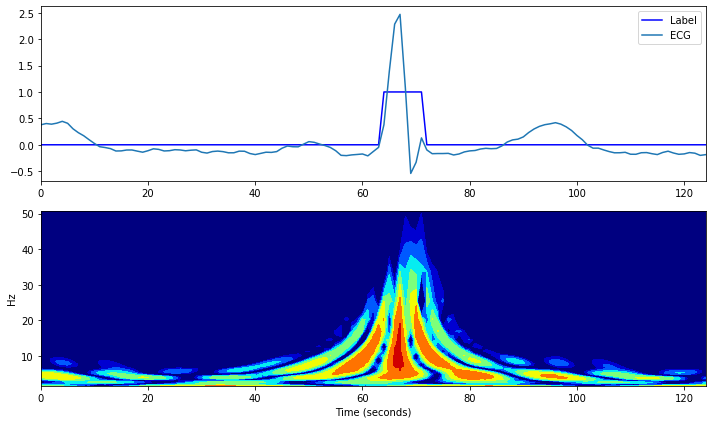

sel117
sel123
sel14046
sel14157
sel14172


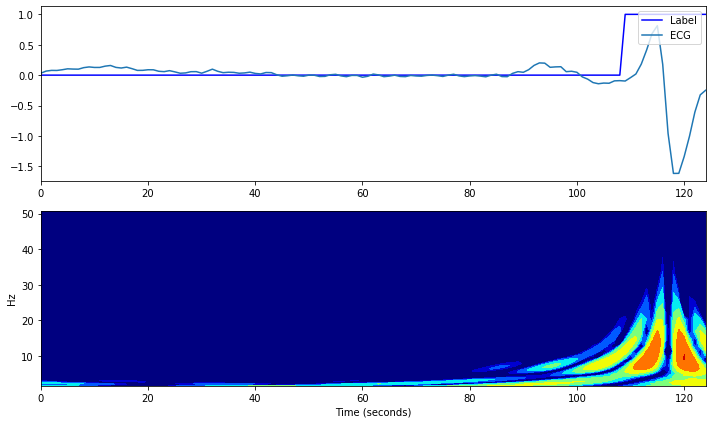

sel15814
sel16265
sel16272
sel16273
sel16420
sel16483
sel16539
sel16773
sel16786
sel16795
sel17152
sel17453
sel213
sel221
sel223
sel230
sel231


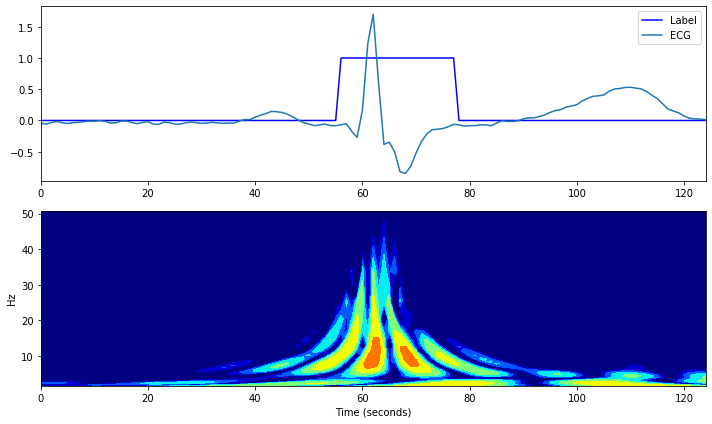

sel232
sel233
sel30
sel301
sel302
sel306
sel307
sel308
sel31
sel310
sel32
sel33
sel34
sel35
sel36
sel37
sel38
sel39
sel40
sel41
sel42
sel43
sel44
sel45
sel46
sel47
sel48
sel49
sel50


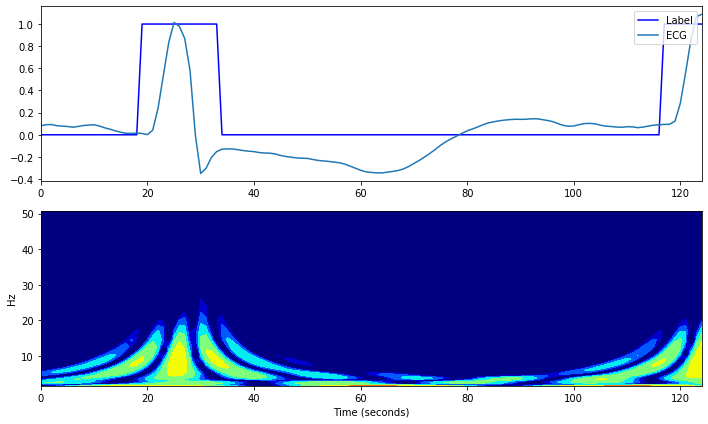

sel51
sel52
sel803
sel808
sel811
sel820
sel821
sel840
sel847
sel853
sel871


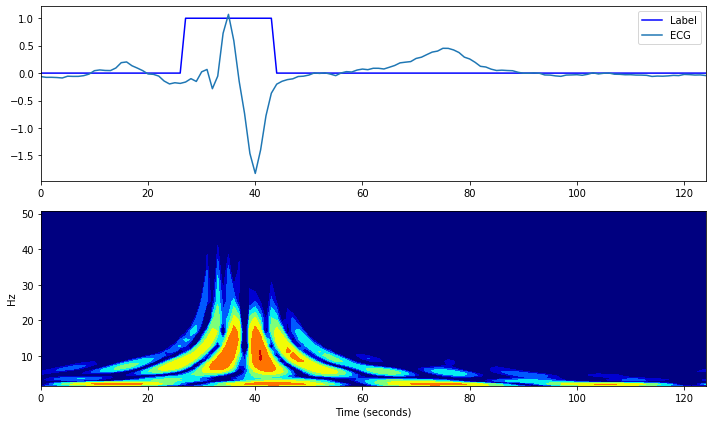

sel872
sel873
sel883
sel891
sele0104
sele0106
sele0107
sele0110
sele0111
sele0112
sele0114
sele0116
sele0121
sele0122
sele0124
sele0126
sele0129
sele0133
sele0136
sele0166
sele0170
sele0203
sele0210
sele0211
sele0303
sele0405
sele0406
sele0409
sele0411
sele0509
sele0603
sele0604
sele0606
sele0607
sele0609
sele0612
sele0704
sel100
sel102
sel103
sel104
sel114
sel116


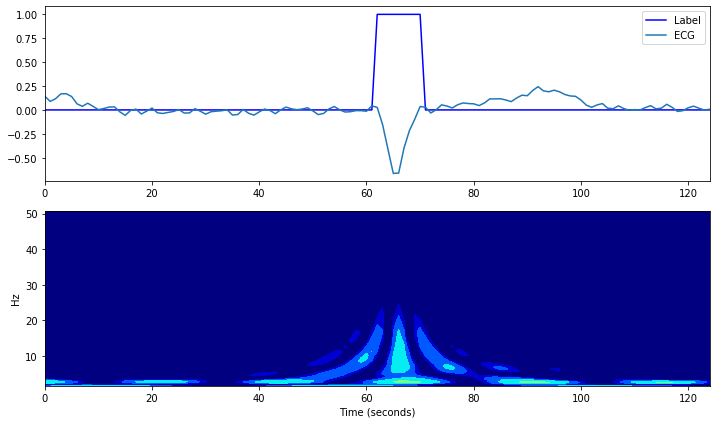

sel117
sel123
sel14046
sel14157
sel14172
sel15814
sel16265
sel16272
sel16273
sel16420
sel16483
sel16539
sel16773
sel16786
sel16795
sel17152
sel17453
sel213
sel221
sel223
sel230
sel231
sel232
sel233
sel30
sel301
sel302
sel306
sel307
sel308
sel31
sel310
sel32
sel33
sel34
sel35
sel36
sel37
sel38
sel39
sel40
sel41
sel42
sel43
sel44
sel45
sel46
sel47
sel48
sel49
sel50
sel51
sel52
sel803
sel808
sel811
sel820
sel821
sel840
sel847
sel853
sel871
sel872
sel873
sel883
sel891
sele0104
sele0106
sele0107
sele0110
sele0111
sele0112
sele0114
sele0116
sele0121
sele0122
sele0124
sele0126
sele0129
sele0133
sele0136
sele0166
sele0170
sele0203
sele0210
sele0211
sele0303
sele0405
sele0406
sele0409
sele0411
sele0509
sele0603
sele0604
sele0606
sele0607
sele0609
sele0612
sele0704
total number of windows: 11828


In [5]:
#window the data
windows_ch1 = df.apply(get_windows, channel='ch1', axis=1)
windows_ch1 = pd.DataFrame(windows_ch1)
windows_ch1 = pd.DataFrame([item for sublist in windows_ch1.values for item in sublist[0]])

#take the first 90% as training and the last 10% as testing
train_ch1 = windows_ch1.iloc[0:int(len(windows_ch1)*0.9)]
test_ch1 = windows_ch1.iloc[int(len(windows_ch1)*0.9)+1:]

windows_ch2 = df.apply(get_windows, channel='ch2', axis=1)
windows_ch2 = pd.DataFrame(windows_ch2)
windows_ch2 = pd.DataFrame([item for sublist in windows_ch2.values for item in sublist[0]])

#take the first 90% as training and the last 10% as testing
train_ch2 = windows_ch2.iloc[0:int(len(windows_ch2)*0.9)]
test_ch2 = windows_ch2.iloc[int(len(windows_ch2)*0.9)+1:]

#combine the two channels
train = pd.concat((train_ch1, train_ch2)).reset_index(drop=True)
test = pd.concat((test_ch1, test_ch2)).reset_index(drop=True)
print('total number of windows: %i' % (len(train) + len(test)))

#save as separate files
train.to_pickle('train.pkl', protocol=4)
test.to_pickle('test.pkl', protocol=4)
